In [1]:
# Make sure to install the requirements with pip install -r requirements.txt

from julia import Julia
import pysr

import os
os.chdir('..')
from matplotlib import pyplot as plt
import numpy as np
import torch
from lib.model import get_model_and_optim
from lib.data import prepare_nuclear_data
from lib.utils import  PlottingContext, IO, get_rms
from sklearn.decomposition import PCA
from lib.data import semi_empirical_mass_formula, BW2_mass_formula
import seaborn as sns
from lib.data import semi_empirical_mass_formula, BW2_mass_formula
sns.set_style('white')
sns.set_context('paper')
import warnings
import tqdm
import pickle
import time

import glob
locations = glob.glob('/export/d0/kitouni/data/experiments/long-runs/*')

keys = [l.split('/')[-1].split('-')[1] for l in locations]
def cleanup(name):
    if '+' in name: return 'all'
    while name[-1].isdigit() or name[-1] == '.':
        name = name[:-1]
    return name
keys = [cleanup(k) for k in keys]
locations = {key:l for key, l in zip(keys, locations)}
task_rms_values = {}

In [2]:
model_name = 'all'
location = locations[model_name]
args = IO.load_args(f"{location}/args.yaml")
args.DEV = "cpu"
data = prepare_nuclear_data(args)
model = get_model_and_optim(data, args)[0]
model.load_state_dict(torch.load(IO.load_latest_model(location), map_location=args.DEV))

Loading model from /export/d0/kitouni/data/experiments/long-runs/long_run-binding100+z1+n1+radius0.02+qa200+qbm200+qbm_n200+qec200+sn200+sp200-seed0/ckpts/model.pt


<All keys matched successfully>

In [3]:
def get_penultimate_acts(model, X):
    # Save the last layer activations
    acts = torch.zeros(len(X), args.HIDDEN_DIM, device=args.DEV)
    # save the activations fed into the readout layer
    hook = model.readout.register_forward_pre_hook(
        lambda m, i: acts.copy_(i[0].detach())
    )
    model(X)
    hook.remove()
    return acts

X = data.X 
y = data.y.view(-1)
mask = (X[:, 2] == 0) & ~torch.isnan(y)
X, y = X[mask], y[mask]

acts = get_penultimate_acts(model, X)

In [4]:
pca = PCA(n_components=10)
pca.fit(acts.detach().cpu().numpy())
acts_pca = pca.transform(acts.detach().cpu().numpy())
print(pca.explained_variance_ratio_)

[9.7697723e-01 9.7878315e-03 4.8781605e-03 1.2566504e-03 9.9159940e-04
 7.7776390e-04 4.7332278e-04 3.5362216e-04 3.0044632e-04 2.4442002e-04]


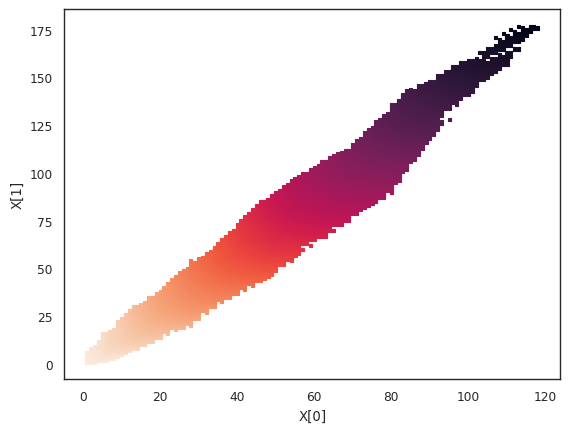

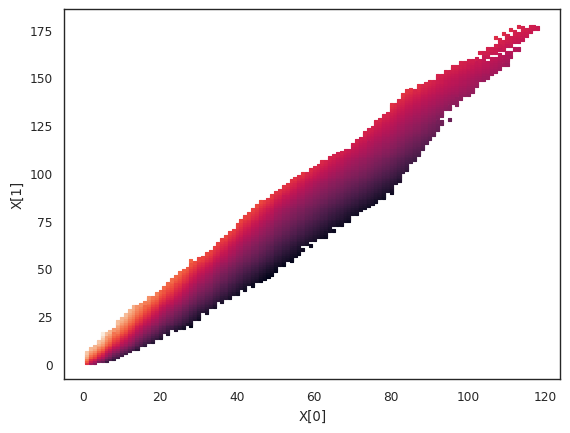

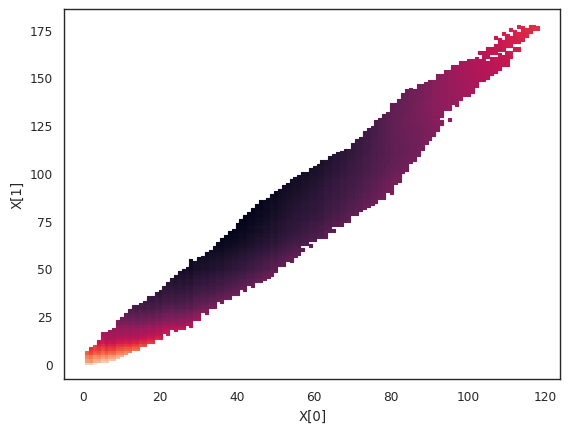

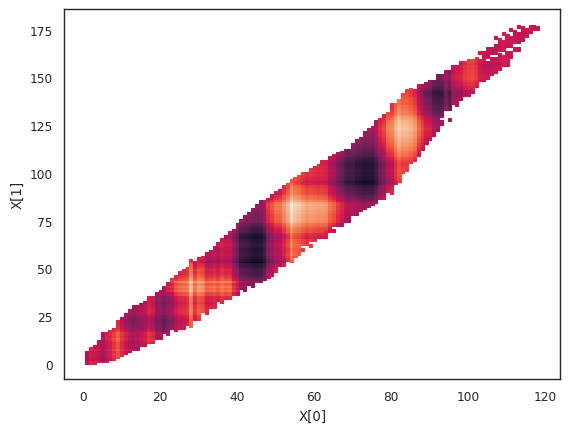

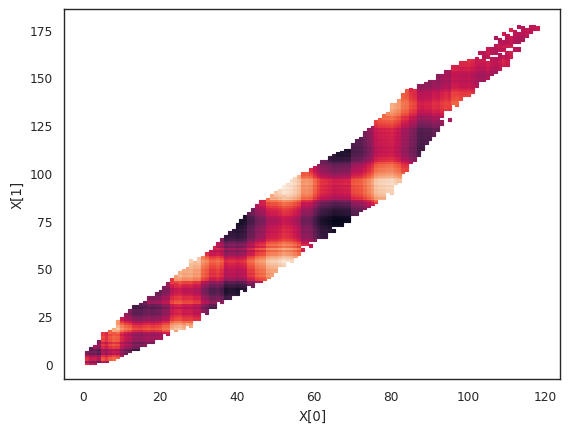

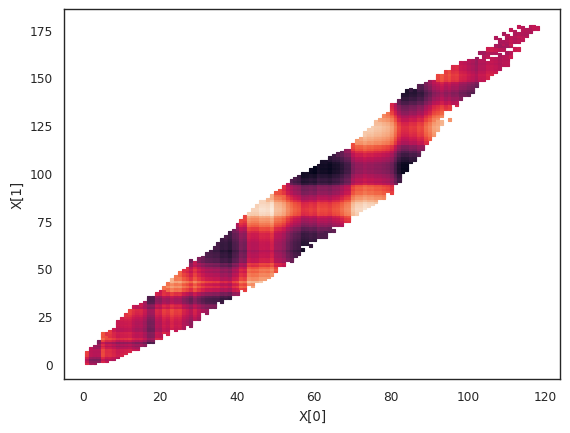

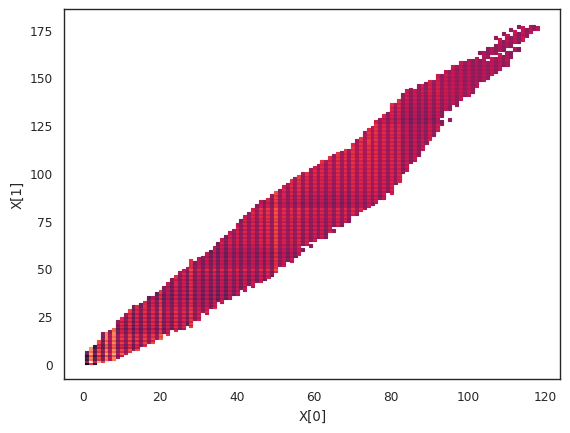

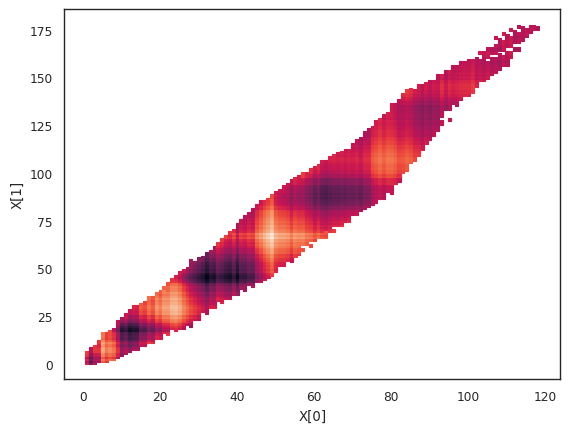

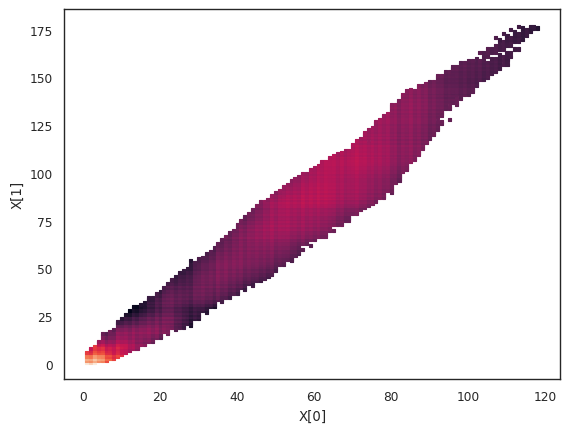

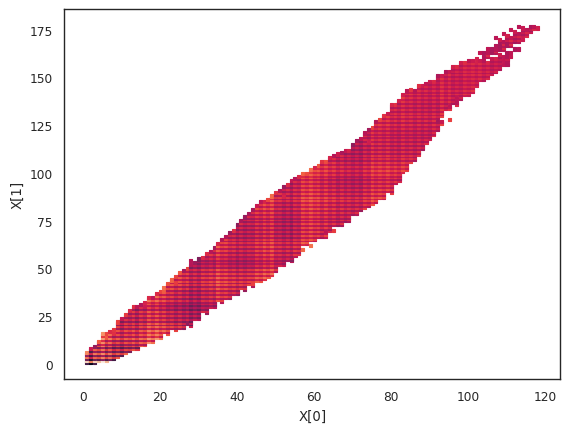

In [5]:
# visualize PCs as a function of X[0] and X[1]
for i in range(pca.n_components_):
    plt.scatter(X[:, 0], X[:, 1], c=acts_pca[:, i], s=5, marker='s')
    plt.xlabel(f"X[0]")
    plt.ylabel(f"X[1]")
    plt.show()

In [6]:
from pysr import PySRRegressor
from functools import partial

sr_factory = partial(PySRRegressor,
    niterations=200,  # < Increase me for better results
    binary_operators=["+", "*"],
    unary_operators=[
        "sin",
        "inv(x) = 1/x",
        # ^ Custom operator (julia syntax)
        "parity(x) = x % 2",
    ],
    extra_sympy_mappings={"inv": lambda x: 1 / x, "parity": lambda x: x % 2},
    # ^ Define operator for SymPy as well
    loss="loss(prediction, target) = (prediction - target)^2",
    # ^ Custom loss function (julia syntax)
    ncyclesperiteration=300,
)

In [8]:
FORCE = False


os.makedirs(f"plots/long-runs/{model_name}/equations", exist_ok=True)
inputs = X[:, :2].detach().cpu().numpy()
# fit the symbolic regression model to the data
equations = []
with warnings.catch_warnings():
    warnings.simplefilter("ignore")
    for i, feature in enumerate(tqdm.tqdm(acts_pca.T)):
        time.sleep(2)
        fname = f"plots/long-runs/{model_name}/equations_old/{i}.pkl"
        if not os.path.exists(fname) or FORCE:
            sr = sr_factory()
            sr.fit(inputs, feature)
            equations.append(sr)
            # pickle.dump(sr, open(fname, 'wb'), protocol=pickle.HIGHEST_PROTOCOL)
        else:
            equations.append(pickle.load(open(fname, 'rb')))

        # make predictions
        lowest_loss_idx = equations[-1].equations_.loss.argmin()
        y_pred = equations[-1].predict(inputs, lowest_loss_idx)
        recomputed_loss = ((feature - y_pred)**2).mean()

        loss = equations[-1].equations_.loss[lowest_loss_idx]
        print(f"Loss: {loss} vs {recomputed_loss}, var: {np.var(feature)}")
print("Done")

 10%|█         | 1/10 [00:02<00:18,  2.01s/it]

Loss: 0.01327427 vs 0.42781379338472664, var: 30.006174087524414


 20%|██        | 2/10 [00:04<00:16,  2.01s/it]

Loss: 0.010952879 vs 0.016792160461021048, var: 0.30061614513397217


 30%|███       | 3/10 [00:06<00:14,  2.04s/it]

Loss: 0.0040708035 vs 0.006129820275943135, var: 0.14982442557811737


 40%|████      | 4/10 [00:08<00:12,  2.05s/it]

Loss: 0.010579419 vs 0.010169435404040885, var: 0.03859582543373108


 50%|█████     | 5/10 [00:10<00:10,  2.05s/it]

Loss: 0.007133261 vs 0.0071503310166624685, var: 0.030455194413661957


 60%|██████    | 6/10 [00:12<00:08,  2.05s/it]

Loss: 0.006415032 vs 0.006829870892060572, var: 0.02388763800263405


 70%|███████   | 7/10 [00:14<00:06,  2.06s/it]

Loss: 0.004704276 vs 0.02544957066714982, var: 0.014537280425429344


 80%|████████  | 8/10 [00:16<00:04,  2.07s/it]

Loss: 0.0030466046 vs 0.02605784030535973, var: 0.010860884562134743


 90%|█████████ | 9/10 [00:18<00:02,  2.06s/it]

Loss: 0.002523411 vs 0.0036616741034501384, var: 0.009227681905031204


100%|██████████| 10/10 [00:20<00:00,  2.05s/it]

Loss: 0.0059130536 vs 0.010253550220243822, var: 0.007506918162107468
Done


In [14]:
def inverse_transform(tensor, data):
    min_ = torch.from_numpy(data.regression_transformer.data_min_).to(tensor.device)
    max_ = torch.from_numpy(data.regression_transformer.data_max_).to(tensor.device)
    return tensor * (max_ - min_) + min_

def get_preds_from_acts(acts):
    pred = model.readout(acts)
    pred = inverse_transform(pred, data)
    return pred[:, 0]

In [24]:
file = "hall_of_fame_2024-01-17_155121.777.pkl"
sr = PySRRegressor.from_file(file)
sr.set_params(extra_sympy_mappings={"inv": lambda x: 1 / x, "parity": lambda x: x % 2})
sr.refresh()
equations[0] = sr
sr.predict(inputs, -1)

Checking if hall_of_fame_2024-01-17_155121.777.pkl exists...
Loading model from hall_of_fame_2024-01-17_155121.777.pkl


array([ 11.78171832,  11.74248784,  11.63777862, ..., -11.05643053,
       -11.12220846, -11.10033894])

In [44]:
print(equations[0].latex())

\left(0.000178 x_{0} - 0.0996\right) \left(x_{1} + \left(x_{0} - 0.348\right) \sin{\left(\frac{1.06 \cdot \left(1.07 x_{1} + 1.86\right)}{x_{0}} \right)} + 1.91\right) + 12.1


In [41]:
# combine the predictions of the symbolic regression models
# into a vector of features and use the same linear regression parameters from before
# to predict the output
sr_features = np.zeros((len(inputs), len(equations)))
for i, (sr, feat) in enumerate(zip(equations, acts_pca.T)):
    # idx = sr.equations_.score.values.argsort()[::-1][0] # select the best pareto front
    # idx = sr.equations_.loss.values.argsort()[0] # select the best equation by loss
    # pred = sr.predict(inputs, idx)
    pred = sr.predict(inputs)
    if i == 0:
        print((((pred - feat)**2).mean()), feat.std()**2)
    sr_features[:, i] = pred
sr_features = torch.tensor(sr_features, device=args.DEV).float()

# We will get predictions in three different ways:
# 1. use the model readout layer
# 2. use a linear regression directly to the target
# 3. use a linear regression from the original PCA features

# 1. use the model readout layer
sr_features[:, 1:] = 0
acts = pca.inverse_transform(sr_features.detach().cpu().numpy())
acts = torch.tensor(acts, device=args.DEV).float()
pred = get_preds_from_acts(acts)
# print("Model readout layer", (pred - y).pow(2).mean().sqrt().item())


# 2. use a linear regression directly to the target
from sklearn.linear_model import LinearRegression
lr = LinearRegression()
lr.fit(sr_features.detach().cpu().numpy(), y.detach().cpu().numpy())
pred = lr.predict(sr_features.detach().cpu().numpy())
print("Linear regression", ((pred - y.detach().cpu().numpy())**2).mean()**0.5)
print()

0.006788403681274292 30.006171508724947
Linear regression 13580.489534622822



In [15]:
acts = get_penultimate_acts(model, X)
acts = acts.detach().cpu().numpy()
acts_pca = pca.transform(acts)
# acts_pca[:, 1:] = 0
acts = pca.inverse_transform(acts_pca)

acts = torch.tensor(acts, device=args.DEV).float()
pred = get_preds_from_acts(acts)
print((pred - y).pow(2).mean().sqrt())

tensor(965.6104, dtype=torch.float64, grad_fn=<SqrtBackward0>)


In [27]:
# now let's do direct SR on the final target
sr = sr_factory()
sr.fit(inputs, y.detach().cpu().numpy())


/work/submit/kitouni/miniconda3/envs/sandbox/lib/python3.10/site-packages/pysr/sr.py:1346: UserWarning: Note: it looks like you are running in Jupyter. The progress bar will be turned off.
  warnings.warn(
/work/submit/kitouni/miniconda3/envs/sandbox/lib/python3.10/site-packages/pysr/julia_helpers.py:162: UserWarning: `torch` was loaded before the Julia instance started. This may cause a segfault when running `PySRRegressor.fit`. To avoid this, please run `pysr.julia_helpers.init_julia()` *before* importing `torch`. For updates, see https://github.com/pytorch/pytorch/issues/78829
  warnings.warn(


Compiling Julia backend...


/work/submit/kitouni/miniconda3/envs/sandbox/lib/python3.10/site-packages/julia/juliainfo.py:93: UserWarning: julia warned:
Juliaup configuration is locked by another process, waiting for it to unlock.
  warnings.warn("{} warned:\n{}".format(julia, stderr))


In [27]:
pred = sr.predict(inputs, sr.equations_.loss.argmin())
print("SR", ((pred - y.detach().cpu().numpy())**2).mean()**0.5)

SR 2259288.174457114


In [29]:
# semf rms
Z, N = inputs.T
preds = (semi_empirical_mass_formula(Z, N))* (N+Z)
print("SEMF", ((preds - y.detach().cpu().numpy())**2).mean()**0.5)

SEMF 7928.02400004463


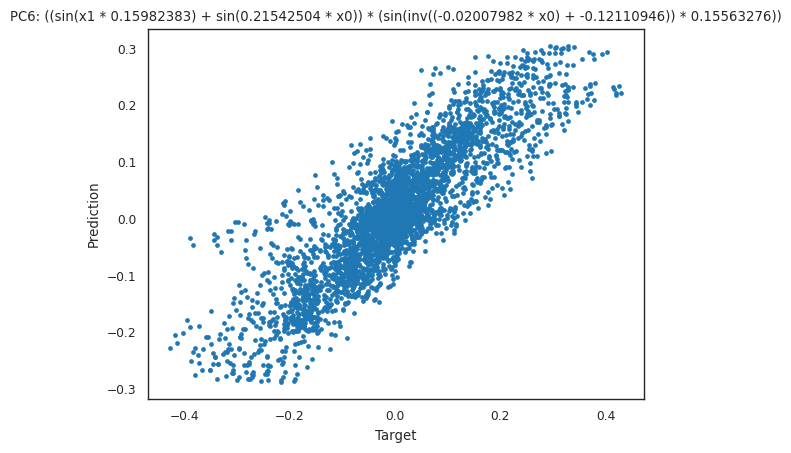

In [48]:
pc_idx = 6
acts = get_penultimate_acts(model, X)
acts = acts.detach().cpu().numpy()
acts_pca = pca.transform(acts)
idx = sr.equations_.loss.argmin()
function = equations[pc_idx].equations_.equation[idx]
preds = equations[pc_idx].predict(inputs, idx)
tgt = acts_pca[:, pc_idx]
plt.plot(tgt, preds, '.')
plt.xlabel("Target")
plt.ylabel("Prediction")
plt.title(f"PC{pc_idx}: " + function)
plt.show()